## Part 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import DataLoader, random_split, Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define the CNN model with a modified fully connected layer
class CustomCNN(nn.Module):
    def __init__(self, pretrained_weights):
        super(CustomCNN, self).__init__()
        # Load pre-trained weights for the convolutional layers
        self.pretrained_cnn = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)

        # Modify fully connected layer for binary classification (2 classes)
        self.pretrained_cnn.fc = nn.Linear(512, 2)

    def forward(self, x):
        return self.pretrained_cnn(x)


# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset_all = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset_all = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Create custom dataset with only class 0 (airplane) and class 1 (automobile)
custom_classes = [0, 1]
train_dataset = [item for i, item in enumerate(trainset_all) if trainset_all.targets[i] in custom_classes]
test_dataset = [item for i, item in enumerate(testset_all) if testset_all.targets[i] in custom_classes]

Files already downloaded and verified
Files already downloaded and verified


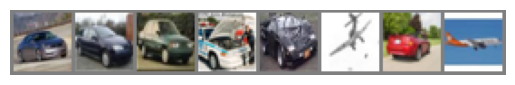

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch [1/10] - Loss: 0.1982 - Accuracy: 0.9258
Epoch [2/10] - Loss: 0.0959 - Accuracy: 0.9642
Epoch [3/10] - Loss: 0.0520 - Accuracy: 0.9801
Epoch [4/10] - Loss: 0.0409 - Accuracy: 0.9855
Epoch [5/10] - Loss: 0.0360 - Accuracy: 0.9880
Epoch [6/10] - Loss: 0.0300 - Accuracy: 0.9902
Epoch [7/10] - Loss: 0.0297 - Accuracy: 0.9893
Epoch [8/10] - Loss: 0.0179 - Accuracy: 0.9929
Epoch [9/10] - Loss: 0.0160 - Accuracy: 0.9945
Epoch [10/10] - Loss: 0.0207 - Accuracy: 0.9930


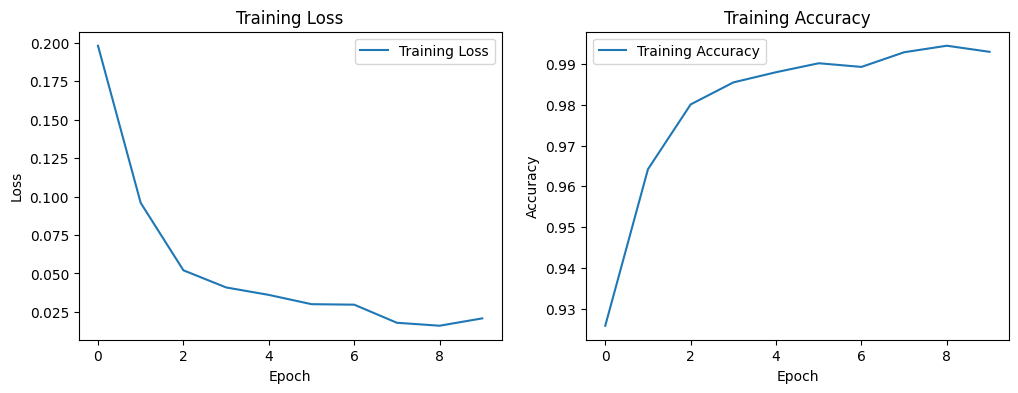

In [ ]:
# Create data loaders
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Randomly select 8 images from the training dataset
num_images_to_display = 8
random_indices = np.random.choice(len(train_dataset), num_images_to_display, replace=False)

selected_images = [train_dataset[i][0] for i in random_indices]
selected_labels = [train_dataset[i][1] for i in random_indices]

# Display the selected images
imshow(torchvision.utils.make_grid(selected_images))

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomCNN(pretrained_weights=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 5: Train the model
num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    average_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / len(train_dataset)

    train_losses.append(average_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f} - Accuracy: {accuracy:.4f}")

# Plot the training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
model.eval()
correct_predictions = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = correct_predictions / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9725


## Part 2

In [ ]:
# Triplet Loss Class
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = torch.norm(anchor - positive, dim=1)
        distance_negative = torch.norm(anchor - negative, dim=1)
        loss = torch.relu(distance_positive - distance_negative + self.margin)
        return loss.mean()

# Custom Dataset for Triplets
class TripletDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.labels = np.array([item[1] for item in dataset])

    def __getitem__(self, index):
        anchor_img, anchor_label = self.dataset[index]
        positive_index = np.random.choice(np.where(self.labels == anchor_label)[0])
        negative_index = np.random.choice(np.where(self.labels != anchor_label)[0])

        positive_img, _ = self.dataset[positive_index]
        negative_img, _ = self.dataset[negative_index]

        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.dataset)

# Custom Model with a modified fully connected layer
class CustomCNN(nn.Module):
    def __init__(self, pretrained_weights):
        super(CustomCNN, self).__init__()
        # Load pre-trained weights for the convolutional layers
        self.pretrained_cnn = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
        # Modify fully connected layer for binary classification (2 classes)
        self.pretrained_cnn.fc = nn.Identity()
        # New fully connected layer for embedding
        self.embedding_layer = nn.Linear(512, 128)

    def forward(self, x):
        features = self.pretrained_cnn(x)
        embedding = self.embedding_layer(features)
        return embedding

In [ ]:
# Data Transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create custom dataset with only class 0 (airplane) and class 1 (automobile)
custom_classes = [0, 1]

# Create custom dataset with triplets
trainset_all = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_dataset = [(item[0], item[1]) for item in trainset_all if item[1] in custom_classes]
triplet_train_dataset = TripletDataset(train_dataset)
triplet_train_loader = DataLoader(dataset=triplet_train_dataset, batch_size=64, shuffle=True)

testset_all = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_dataset = [(item[0], item[1]) for item in testset_all if item[1] in custom_classes]
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch [1/10] - Triplet Loss: 0.3700
Epoch [2/10] - Triplet Loss: 0.1818
Epoch [3/10] - Triplet Loss: 0.0847
Epoch [4/10] - Triplet Loss: 0.0543
Epoch [5/10] - Triplet Loss: 0.0482
Epoch [6/10] - Triplet Loss: 0.0426
Epoch [7/10] - Triplet Loss: 0.0297
Epoch [8/10] - Triplet Loss: 0.0281
Epoch [9/10] - Triplet Loss: 0.0413
Epoch [10/10] - Triplet Loss: 0.0473
Epoch [1/10] - Loss: 1.0634 - Accuracy: 0.6370
Epoch [2/10] - Loss: 0.6882 - Accuracy: 0.7671
Epoch [3/10] - Loss: 0.5597 - Accuracy: 0.8108
Epoch [4/10] - Loss: 0.4529 - Accuracy: 0.8465
Epoch [5/10] - Loss: 0.3793 - Accuracy: 0.8717
Epoch [6/10] - Loss: 0.2756 - Accuracy: 0.9066
Epoch [7/10] - Loss: 0.2153 - Accuracy: 0.9278
Epoch [8/10] - Loss: 0.1984 - Accuracy: 0.9318
Epoch [9/10] - Loss: 0.1298 - Accuracy: 0.9559
Epoch [10/10] - Loss: 0.1127 - Accuracy: 0.9619


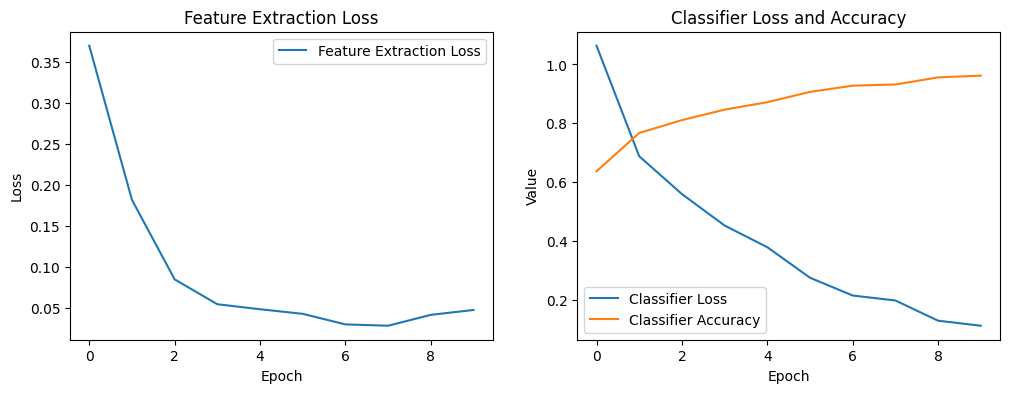

In [ ]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomCNN(pretrained_weights=True).to(device)
triplet_loss = TripletLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model with Triplet Loss
num_epochs = 10
feature_extraction_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for anchor, positive, negative in triplet_train_loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()
        anchor_embedding = model(anchor)
        positive_embedding = model(positive)
        negative_embedding = model(negative)

        loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / len(triplet_train_loader)
    feature_extraction_losses.append(average_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Triplet Loss: {average_loss:.4f}")

# Freeze the embedding layer and add a new fully connected layer for classification
model.embedding_layer.requires_grad = False
model.fc = nn.Linear(128, 2).to(device)

# Prepare data loaders for classification
binary_train_loader = DataLoader(dataset=trainset_all, batch_size=64, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer_classifier = optim.Adam(model.parameters(), lr=0.001)

# Train the model with Cross Entropy Loss
num_epochs_classifier = 10
classifier_losses = []
classifier_accuracies = []
for epoch in range(num_epochs_classifier):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in binary_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_classifier.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_classifier.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    average_loss = running_loss / len(binary_train_loader)
    accuracy = correct_predictions / len(trainset_all)
    classifier_losses.append(average_loss)
    classifier_accuracies.append(accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs_classifier}] - Loss: {average_loss:.4f} - Accuracy: {accuracy:.4f}")

# Plot the training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(feature_extraction_losses, label='Feature Extraction Loss')
plt.title('Feature Extraction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(classifier_losses, label='Classifier Loss')
plt.plot(classifier_accuracies, label='Classifier Accuracy')
plt.title('Classifier Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
model.eval()
correct_predictions = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = correct_predictions / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8760


## Part 3

In [2]:
# Triplet Loss Class
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = torch.norm(anchor - positive, dim=1)
        distance_negative = torch.norm(anchor - negative, dim=1)
        loss = torch.relu(distance_positive - distance_negative + self.margin)
        return loss.mean()

# Custom Dataset for Triplets
class TripletDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.labels = np.array([item[1] for item in dataset])

    def __getitem__(self, index):
        anchor_img, anchor_label = self.dataset[index]
        positive_index = np.random.choice(np.where(self.labels == anchor_label)[0])
        negative_index = np.random.choice(np.where(self.labels != anchor_label)[0])

        positive_img, _ = self.dataset[positive_index]
        negative_img, _ = self.dataset[negative_index]

        return anchor_img, positive_img, negative_img, anchor_label

    def __len__(self):
        return len(self.dataset)

# Custom Model with a modified fully connected layer
class CustomCNN(nn.Module):
    def __init__(self, pretrained_weights):
        super(CustomCNN, self).__init__()
        # Load pre-trained weights for the convolutional layers
        self.pretrained_cnn = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
        # Modify fully connected layer for binary classification (2 classes)
        self.pretrained_cnn.fc = nn.Identity()  # No fully connected layer

        # New fully connected layer for embedding
        self.embedding_layer = nn.Linear(512, 128)

        # Classifier layer
        self.fc_classifier = nn.Linear(128, 2)

    def forward(self, x):
        features = self.pretrained_cnn(x)
        embedding = self.embedding_layer(features)
        logits = self.fc_classifier(embedding)
        return embedding, logits

In [3]:
# Data Transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create custom dataset with only class 0 (airplane) and class 1 (automobile)
custom_classes = [0, 1]

# Create custom dataset with triplets
trainset_all = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_dataset = [(item[0], item[1]) for item in trainset_all if item[1] in custom_classes]
triplet_train_dataset = TripletDataset(train_dataset)
triplet_train_loader = DataLoader(dataset=triplet_train_dataset, batch_size=64, shuffle=True)

testset_all = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_dataset = [(item[0], item[1]) for item in testset_all if item[1] in custom_classes]
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomCNN(pretrained_weights=True).to(device)
triplet_loss = TripletLoss()
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model with both Triplet Loss and Cross-Entropy Loss
num_epochs = 10
train_triplet_losses = []
train_cross_entropy_losses = []
train_accuracies = []
for epoch in range(num_epochs):
    model.train()
    running_triplet_loss = 0.0
    running_cross_entropy_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for anchor, positive, negative, labels in triplet_train_loader:
        anchor, positive, negative, labels = anchor.to(device), positive.to(device), negative.to(device), labels.to(device)

        optimizer.zero_grad()
        anchor_embedding, logits = model(anchor)

        triplet_loss_value = triplet_loss(anchor_embedding, model(positive)[0], model(negative)[0])
        cross_entropy_loss_value = cross_entropy_loss(logits, labels)

        total_loss = triplet_loss_value + cross_entropy_loss_value
        total_loss.backward()
        optimizer.step()

        running_triplet_loss += triplet_loss_value.item()
        running_cross_entropy_loss += cross_entropy_loss_value.item()
        _, predicted = torch.max(logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    average_triplet_loss = running_triplet_loss / len(triplet_train_loader)
    average_cross_entropy_loss = running_cross_entropy_loss / len(triplet_train_loader)
    accuracy = correct_predictions / total_samples

    train_triplet_losses.append(average_triplet_loss)
    train_cross_entropy_losses.append(average_cross_entropy_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Triplet Loss: {average_triplet_loss:.4f} - Cross-Entropy Loss: {average_cross_entropy_loss:.4f}")


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch [1/10] - Triplet Loss: 0.3853 - Cross-Entropy Loss: 0.2052
Epoch [2/10] - Triplet Loss: 0.1600 - Cross-Entropy Loss: 0.1114
Epoch [3/10] - Triplet Loss: 0.0926 - Cross-Entropy Loss: 0.0742
Epoch [4/10] - Triplet Loss: 0.0778 - Cross-Entropy Loss: 0.0598
Epoch [5/10] - Triplet Loss: 0.0741 - Cross-Entropy Loss: 0.0571
Epoch [6/10] - Triplet Loss: 0.0430 - Cross-Entropy Loss: 0.0398
Epoch [7/10] - Triplet Loss: 0.0345 - Cross-Entropy Loss: 0.0319
Epoch [8/10] - Triplet Loss: 0.0275 - Cross-Entropy Loss: 0.0249
Epoch [9/10] - Triplet Loss: 0.0307 - Cross-Entropy Loss: 0.0290
Epoch [10/10] - Triplet Loss: 0.0426 - Cross-Entropy Loss: 0.0364


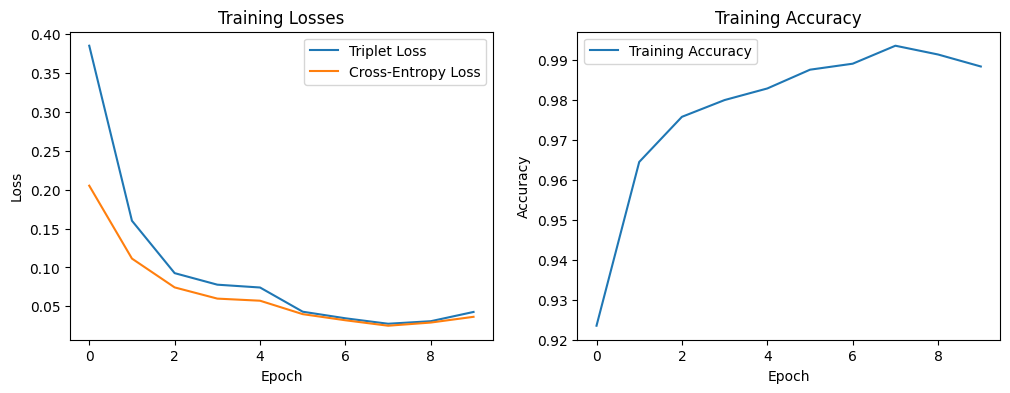

In [5]:
# Plot the training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_triplet_losses, label='Triplet Loss')
plt.plot(train_cross_entropy_losses, label='Cross-Entropy Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
# Evaluate the model on the test set
model.eval()
correct_predictions = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        _, logits = model(inputs)
        _, predicted = torch.max(logits, 1)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = correct_predictions / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9720
